<a href="https://colab.research.google.com/github/Ons-IT/Flight-Delay-Prediction-using-Big-Data/blob/main/BD_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning
import datetime as dt

# Modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
flights_id = '17Y7rW8K8qekFtLtss274rHncX0Jz0QtW'
airports_id = '1Yb54tAzlkt9H6fX6sR1Ylx0wHZADsVZi'
airlines_id = '1keMkVbJWU18ExGZXYwBab6AZnOBYnuo9'
flights_df = pd.read_csv(f'https://drive.google.com/uc?id={flights_id}')
airports_df = pd.read_csv(f'https://drive.google.com/uc?id={airports_id}')
airlines_df = pd.read_csv(f'https://drive.google.com/uc?id={airlines_id}')

In [3]:
# Display first 5 rows
print("First 5 Rows of the (flights_df) Dataset:")
print(flights_df.head())

# Display dataset shape
print(f"Dataset (flights_df) Shape: {flights_df.shape}")  # (rows, columns)

# Display column names
print("\nColumn Names of flights_df:")
print(flights_df.columns)


print("First 5 Rows of the (airports_df) Dataset:")
print(airports_df.head())
# Display dataset shape
print(f"Dataset (airports_df) Shape: {airports_df.shape}")  # (rows, columns)

# Display column names
print("\nColumn Names of airports_df:")
print(airports_df.columns)

print("First 5 Rows of the (airlines_df) Dataset:")
print(airlines_df.head())
# Display dataset shape
print(f"Dataset (airlines_df) Shape: {airlines_df.shape}")  # (rows, columns)

# Display column names
print("\nColumn Names of airlines_df:")
print(airlines_df.columns)





First 5 Rows of the (flights_df) Dataset:
   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS           98.0      N407AS   
1  2015      1    1            4      AA         2336.0      N3KUAA   
2  2015      1    1            4      US          840.0      N171US   
3  2015      1    1            4      AA          258.0      N3HYAA   
4  2015      1    1            4      AS          135.0      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  ARRIVAL_TIME  \
0            ANC                 SEA                  5.0  ...         408.0   
1            LAX                 PBI                 10.0  ...         741.0   
2            SFO                 CLT                 20.0  ...         811.0   
3            LAX                 MIA                 20.0  ...         756.0   
4            SEA                 ANC                 25.0  ...         259.0   

   ARRIVAL_DELAY  DIVERTED  CANCELLED  CANCELLATIO

### 🔍 Step 1: Data Assessment & Summary Statistics

In [ ]:
# Display dataset shapes
print("Flights Dataset Shape:", flights_df.shape)
print("Airports Dataset Shape:", airports_df.shape)
print("Airlines Dataset Shape:", airlines_df.shape)

# Check for missing values in each dataset
print("\nMissing values in flights_df:")
print(flights_df.isnull().sum().sort_values(ascending=False))

print("\nMissing values in airports_df:")
print(airports_df.isnull().sum())

print("\nMissing values in airlines_df:")
print(airlines_df.isnull().sum())

# Summary statistics for numerical columns in flights_df
print("\nDescriptive statistics for flights_df:")
print(flights_df.describe())

# Basic info to check datatypes
print("\nData types and non-null counts:")
print(flights_df.info())

# Count unique values for categorical columns
print("\nUnique airlines in flights_df:", flights_df['AIRLINE'].nunique())
print("Unique origin airports:", flights_df['ORIGIN_AIRPORT'].nunique())
print("Unique destination airports:", flights_df['DESTINATION_AIRPORT'].nunique())


Flights Dataset Shape: (88197, 31)
Airports Dataset Shape: (322, 7)
Airlines Dataset Shape: (14, 2)

Missing values in flights_df:
CANCELLATION_REASON    85975
LATE_AIRCRAFT_DELAY    57501
WEATHER_DELAY          57501
AIRLINE_DELAY          57501
AIR_SYSTEM_DELAY       57501
SECURITY_DELAY         57501
ELAPSED_TIME            2424
AIR_TIME                2424
ARRIVAL_DELAY           2424
WHEELS_ON               2268
TAXI_IN                 2268
ARRIVAL_TIME            2268
WHEELS_OFF              2209
TAXI_OUT                2209
DEPARTURE_TIME          2144
DEPARTURE_DELAY         2144
TAIL_NUMBER              138
FLIGHT_NUMBER              1
AIRLINE                    1
SCHEDULED_TIME             1
ORIGIN_AIRPORT             1
DESTINATION_AIRPORT        1
SCHEDULED_DEPARTURE        1
SCHEDULED_ARRIVAL          1
DISTANCE                   1
DIVERTED                   1
CANCELLED                  1
DAY                        0
MONTH                      0
YEAR                       0

### 🧹 Step 2 Code: Clean Data and Prepare for EDA

In [ ]:


# Step 1: Drop rows where essential flight info is missing
flights_df.dropna(subset=['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE'], inplace=True)

# Convert FLIGHT_NUMBER to int
flights_df['FLIGHT_NUMBER'] = flights_df['FLIGHT_NUMBER'].astype('Int64')

# Step 2: Fill delay-related nulls with 0
delay_columns = [
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
]
flights_df[delay_columns] = flights_df[delay_columns].fillna(0)

# Step 3: Convert HHMM numeric time to readable time
def convert_to_time(val):
    if pd.isnull(val):
        return np.nan
    val = int(val)
    hour = val // 100
    minute = val % 100
    return dt.time(hour=hour % 24, minute=minute % 60)

time_cols = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'WHEELS_OFF',
             'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'WHEELS_ON']

for col in time_cols:
    flights_df[col + '_TIME'] = flights_df[col].apply(convert_to_time)

# Step 4: Create new features
flights_df['DELAY_CATEGORY'] = pd.cut(
    flights_df['ARRIVAL_DELAY'],
    bins=[-np.inf, 0, 15, np.inf],
    labels=['On Time/Early', 'Minor Delay', 'Major Delay']
)

flights_df['DAY_PERIOD'] = flights_df['SCHEDULED_DEPARTURE'].apply(
    lambda x: 'Night' if pd.notnull(x) and (x < 600 or x > 2000) else 'Day'
)

print("✅ Data cleaning complete and features added!")


✅ Data cleaning complete and features added!


### 🔍 Step 3: Exploratory Data Analysis (EDA)

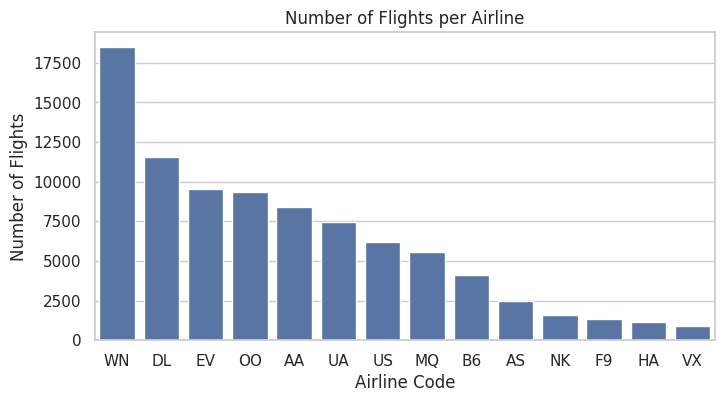

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Set theme
sns.set(style="whitegrid")

# 1️⃣ Number of flights per airline
plt.figure(figsize=(8, 4))
sns.countplot(data=flights_df, x='AIRLINE', order=flights_df['AIRLINE'].value_counts().index)
plt.title('Number of Flights per Airline')
plt.ylabel('Number of Flights')
plt.xlabel('Airline Code')
plt.show()










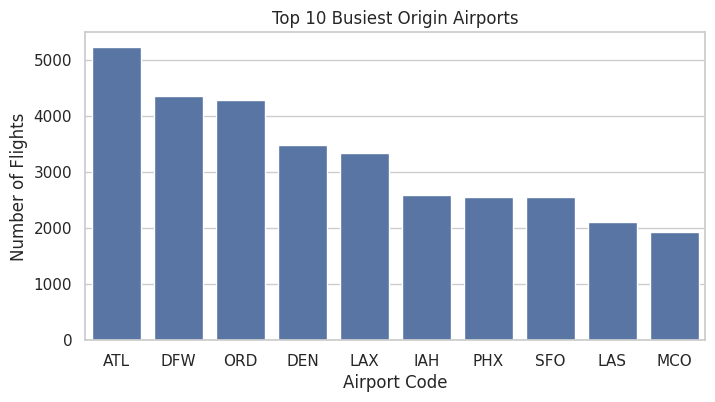

In [ ]:
# 2️⃣ Top 10 Busiest Origin Airports
plt.figure(figsize=(8, 4))
top_airports = flights_df['ORIGIN_AIRPORT'].value_counts().nlargest(10)
sns.barplot(x=top_airports.index, y=top_airports.values)
plt.title('Top 10 Busiest Origin Airports')
plt.ylabel('Number of Flights')
plt.xlabel('Airport Code')
plt.show()

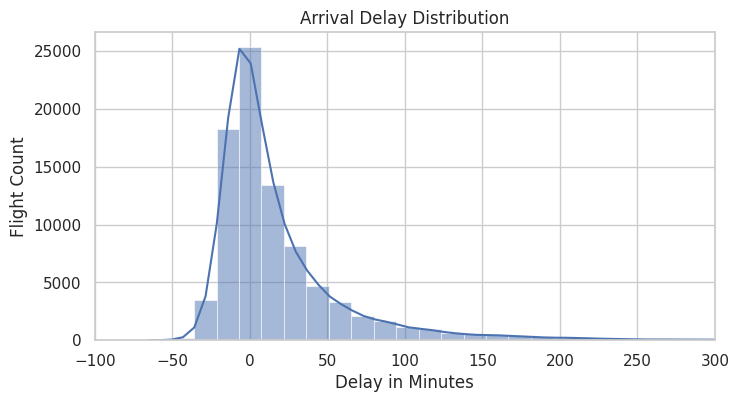

In [ ]:
# 3️⃣ Delay distribution
plt.figure(figsize=(8, 4))
sns.histplot(flights_df['ARRIVAL_DELAY'].dropna(), bins=100, kde=True)
plt.title('Arrival Delay Distribution')
plt.xlabel('Delay in Minutes')
plt.ylabel('Flight Count')
plt.xlim(-100, 300)
plt.show()

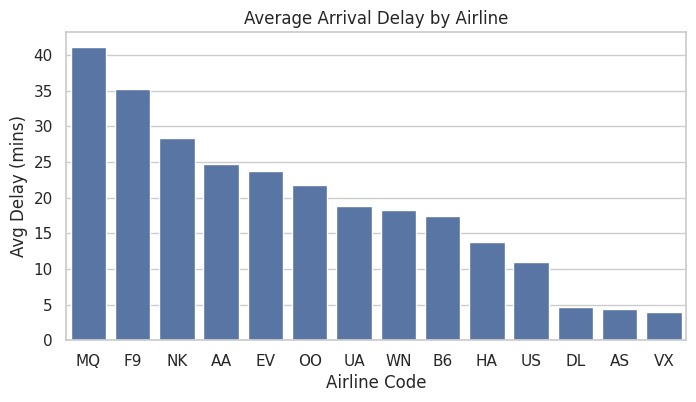

In [ ]:

# 4️⃣ Average delay per airline
plt.figure(figsize=(8, 4))
delay_by_airline = flights_df.groupby('AIRLINE')['ARRIVAL_DELAY'].mean().sort_values(ascending=False)
sns.barplot(x=delay_by_airline.index, y=delay_by_airline.values)
plt.title('Average Arrival Delay by Airline')
plt.ylabel('Avg Delay (mins)')
plt.xlabel('Airline Code')
plt.show()

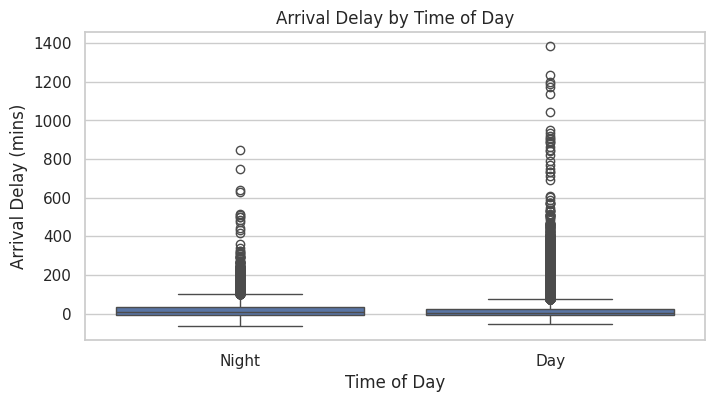

In [ ]:
# 5️⃣ Delay by time of day
plt.figure(figsize=(8, 4))
sns.boxplot(data=flights_df, x='DAY_PERIOD', y='ARRIVAL_DELAY')
plt.title('Arrival Delay by Time of Day')
plt.ylabel('Arrival Delay (mins)')
plt.xlabel('Time of Day')
plt.show()

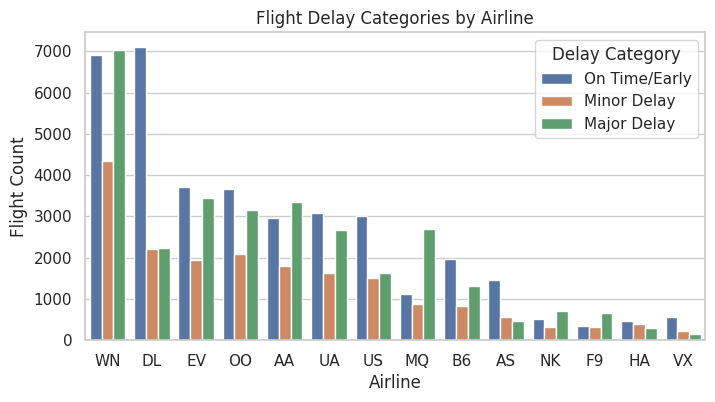

In [ ]:

# 6️⃣ Delay category count by airline
plt.figure(figsize=(8, 4))
sns.countplot(data=flights_df, x='AIRLINE', hue='DELAY_CATEGORY',
              order=flights_df['AIRLINE'].value_counts().index)
plt.title('Flight Delay Categories by Airline')
plt.ylabel('Flight Count')
plt.xlabel('Airline')
plt.legend(title='Delay Category')
plt.show()

### 🔄 Step 4: Feature Selection + Predictive Modeling

Step 4.1: Add a New Target Column for Classification

In [ ]:
# Binary classification target: 1 if arrival delay > 15 mins, else 0
flights_df['DELAYED'] = flights_df['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 15 else 0)


 Step 4.2: Feature Selection

In [ ]:
# Select features for modeling
model_df = flights_df[[
    'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
    'DAY_OF_WEEK', 'DAY_PERIOD', 'DISTANCE', 'SCHEDULED_DEPARTURE',
    'DELAYED'
]].dropna()

# Encode categorical features
from sklearn.preprocessing import LabelEncoder

for col in ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DAY_PERIOD']:
    le = LabelEncoder()
    model_df[col] = le.fit_transform(model_df[col])

# Split X and y
X = model_df.drop('DELAYED', axis=1)
y = model_df['DELAYED']


Step 4.3: Train-Test Split + Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7202947845804989

Confusion Matrix:
 [[9971 1638]
 [3296 2735]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80     11609
           1       0.63      0.45      0.53      6031

    accuracy                           0.72     17640
   macro avg       0.69      0.66      0.66     17640
weighted avg       0.71      0.72      0.71     17640



### 🔁 Step 5: Improve Model Performance

Step 5.1: Feature Importance Plot

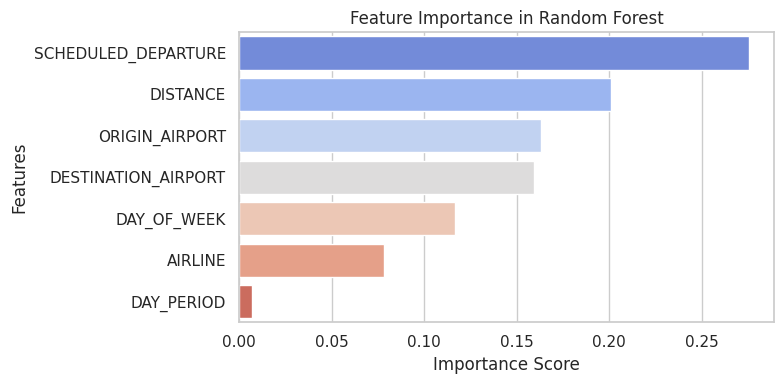

In [ ]:
# Feature Importance Plot
importances = rf_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
sns.barplot(x=importances[indices], y=feature_names[indices], palette='coolwarm')
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


 Step 5.2: Step 5.2: Handle Class Imbalance (Apply SMOTE ) and Re-Evaluate the Model

In [ ]:


from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Apply SMOTE to balance delayed vs. on-time flights
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the balanced dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train a new Random Forest model
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_smote.fit(X_train, y_train)

# Predict
y_pred_smote = rf_model_smote.predict(X_test)

# Evaluate
print("✅ SMOTE Model Accuracy:", accuracy_score(y_test, y_pred_smote))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))


✅ SMOTE Model Accuracy: 0.7581749700393768

Confusion Matrix:
 [[8947 2834]
 [2816 8767]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76     11781
           1       0.76      0.76      0.76     11583

    accuracy                           0.76     23364
   macro avg       0.76      0.76      0.76     23364
weighted avg       0.76      0.76      0.76     23364



### Step 6: Final Evaluation & Interpretation

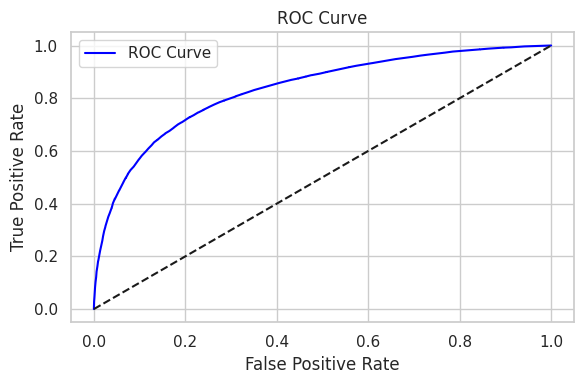

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

# Predict probability scores for class 1 (delayed flights)
y_probs = rf_model_smote.predict_proba(X_test)[:, 1]

# 1️⃣ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()




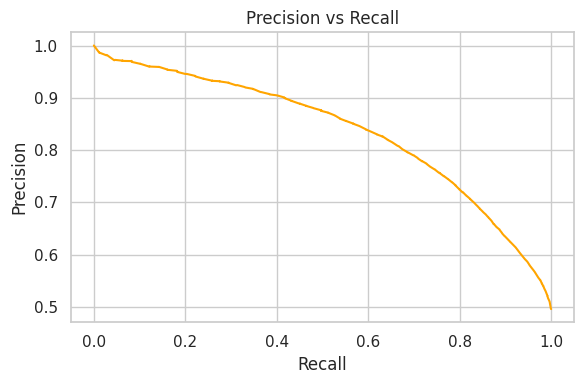

In [ ]:
# 2️⃣ Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label='Precision-Recall Curve', color='orange')
plt.title('Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
plt.show()

In [ ]:

# 3️⃣ AUC Score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"🔹 ROC AUC Score: {roc_auc:.4f}")


🔹 ROC AUC Score: 0.8332


### 💾 Step 7 Code: Save the Final Model

In [ ]:
import joblib

# Save your trained model
joblib.dump(rf_model_smote, 'flight_delay_rf_model.pkl')

['flight_delay_rf_model.pkl']

Done by : Ons